<a href="https://colab.research.google.com/github/Farski96/DESAFIODIO/blob/main/FIAP_FASE_3_FINETUNING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1️⃣ INSTALAÇÃO RÁPIDA
!pip install -q --upgrade pip
!pip install -q accelerate bitsandbytes einops sentencepiece
!pip install -q git+https://github.com/huggingface/peft.git
!pip install -q unsloth xformers trl
!pip install -q --upgrade transformers datasets tqdm
!pip install -U pyarrow
!pip install -U bitsandbytes transformers datasets pyarrow accelerate peft


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 74.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
unsloth 2025.10.1 requires transformers!=4.52.0,!=4.52.1,!=4.52.2,!=4.52.3,!=4.53.0,!=4.54.0,!=4.55.0,!=4.55.1,<=4.56.2,>=4.51.3, but you have transformers 4.57.0 wh

In [2]:
# 2️⃣ IMPORTS
import os
import torch
import time
import gc
from google.colab import drive
from pathlib import Path
from datasets import load_dataset
from datasets import load_from_disk
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling,
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

print("✅ Pacotes importados com sucesso!\n")



✅ Pacotes importados com sucesso!



In [3]:
# 3️⃣ MONTAR DRIVE
from google.colab import drive
drive.mount('/content/drive')

# 4️⃣ CONFIGURAR DIRETÓRIOS
BASE_DIR = Path("/content/drive/MyDrive/tc_fiap_ft1")
BASE_DIR.mkdir(parents=True, exist_ok=True)

INPUT_FILE = BASE_DIR / "trn.json"
CHUNKS_DIR = BASE_DIR / "chunks"
OUTPUT_DIR = BASE_DIR / "output"
TOKENIZED_DIR = BASE_DIR / "tokenized_datasets"

for d in [CHUNKS_DIR, OUTPUT_DIR, TOKENIZED_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print(f"📁 Diretórios configurados:")
print(f"   Base: {BASE_DIR}")
print(f"   Output: {OUTPUT_DIR}\n")

# 5️⃣ VERIFICAR GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"🖥️  GPU: {gpu_name}")
    print(f"💾 VRAM: {gpu_memory:.0f} GB\n")
else:
    print("⚠️  Sem GPU detectada!\n")



Mounted at /content/drive
📁 Diretórios configurados:
   Base: /content/drive/MyDrive/tc_fiap_ft1
   Output: /content/drive/MyDrive/tc_fiap_ft1/output

🖥️  GPU: NVIDIA A100-SXM4-80GB
💾 VRAM: 85 GB



In [4]:
# 6️⃣ CARREGAR MODELO E TOKENIZER
print("📦 Carregando modelo LLaMA 3.2-1B...")
model_name = "unsloth/Llama-3.2-1B-bnb-4bit"

tokenizer = AutoTokenizer.from_pretrained(model_name)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    load_in_4bit=True,
    device_map="auto",
    torch_dtype=torch.bfloat16,
)

model = prepare_model_for_kbit_training(model)
model.gradient_checkpointing_enable()

print("✅ Modelo carregado!\n")

# 7️⃣ CONFIGURAR LORA (Otimizado para velocidade)
print("🔧 Aplicando LoRA...")
lora_config = LoraConfig(
    r=16,  # Rank reduzido para velocidade
    lora_alpha=32,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],  # Menos módulos = mais rápido
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)
print(f"✅ LoRA aplicado!")
model.print_trainable_parameters()
print()

📦 Carregando modelo LLaMA 3.2-1B...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
/usr/local/lib/python3.12/dist-packages/transformers/quantizers/auto.py:239: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)


model.safetensors:   0%|          | 0.00/1.03G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/230 [00:00<?, ?B/s]

✅ Modelo carregado!

🔧 Aplicando LoRA...
✅ LoRA aplicado!
trainable params: 3,407,872 || all params: 1,239,222,272 || trainable%: 0.2750



In [ ]:

# 8️⃣ CARREGAR OU PROCESSAR DATASETS
train_path = TOKENIZED_DIR / "train"
eval_path = TOKENIZED_DIR / "eval"

if train_path.exists() and eval_path.exists():
    print("♻️  Carregando datasets tokenizados do cache...")
    tokenized_train = load_from_disk(str(train_path))
    tokenized_eval = load_from_disk(str(eval_path))
    print(f"✅ Train: {len(tokenized_train):,} | Eval: {len(tokenized_eval):,}\n")

else:
    print("🔄 Processando datasets pela primeira vez...\n")

    # Carregar JSONs
    json_files = sorted([str(f) for f in CHUNKS_DIR.glob("*.json")])
    if not json_files:
        print(f"❌ Nenhum arquivo JSON em {CHUNKS_DIR}")
        print(f"💡 Coloque seus arquivos chunk_*.json em: {CHUNKS_DIR}\n")
        raise FileNotFoundError("Arquivos JSON não encontrados!")

    print(f"📊 Carregando {len(json_files)} arquivo(s)...")
    dataset = load_dataset("json", data_files=json_files, split="train")

    # Split train/eval
    split = dataset.train_test_split(test_size=0.05, seed=42)  # 5% eval (menos = mais rápido)
    train_dataset = split["train"]
    eval_dataset = split["test"]

    print(f"📊 Train: {len(train_dataset):,} | Eval: {len(eval_dataset):,}")

    # Tokenização
    max_length = 1024  #
    def preprocess(examples):
        """Formata exemplos no padrão Alpaca"""

        # Pegar títulos (se não existir, usa string vazia)
        titles = examples.get("title", [])
        if not titles:
            titles = [""] * len(examples.get("content", []))

        # Pegar conteúdos
        contents = examples.get("content", [])

        # Criar lista de textos no formato ALPACA
        texts = []
        for title, content in zip(titles, contents):
            # Formato Alpaca: Instruction → Input → Response
            alpaca_prompt = f"""

          ### Instruction:
          Descreva o produto a seguir de forma detalhada e persuasiva.

          ### Input:
          {title}

          ### Response:
          {content}"""
            texts.append(alpaca_prompt)

        # Tokenizar
        tokenized = tokenizer(
            texts,
            truncation=True,
            padding="max_length",
            max_length=max_length,
            return_tensors=None
        )
        tokenized["labels"] = tokenized["input_ids"].copy()
        return tokenized

    print("🔄 Tokenizando (isso pode levar 10-15 min)...")
    tokenized_train = train_dataset.map(
        preprocess,
        batched=True,
        batch_size=2000,
        num_proc=4,
        remove_columns=train_dataset.column_names,
        desc="Tokenizando treino"
    )

    tokenized_eval = eval_dataset.map(
        preprocess,
        batched=True,
        batch_size=2000,
        num_proc=4,
        remove_columns=eval_dataset.column_names,
        desc="Tokenizando eval"
    )

    # Salvar para próximas execuções
    print("💾 Salvando cache...")
    tokenized_train.save_to_disk(str(train_path))
    tokenized_eval.save_to_disk(str(eval_path))
    print(f"✅ Cache salvo em: {TOKENIZED_DIR}\n")

# 9️⃣ DATA COLLATOR
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,
    return_tensors="pt"
)

# 🔟 TRAINING ARGUMENTS - MÁXIMA VELOCIDADE
print("⚙️  Configurando treinamento...\n")
training_args = TrainingArguments(
    output_dir="/tmp/training_output",  # /tmp = mais rápido que Drive

    # BATCH - Otimizado para A100 sem estourar RAM
    per_device_train_batch_size=32,  # Máximo seguro para A100
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=1,  # Sem acumulação = mais rápido

    # LEARNING
    learning_rate=5e-4,
    lr_scheduler_type="cosine",
    warmup_ratio=0.03,

    # PRECISÃO
    bf16=True,
    bf16_full_eval=True,

    # LOGGING MÍNIMO
    logging_steps=100,
    logging_first_step=True,

    # SEM SALVAMENTO DURANTE TREINO
    save_strategy="no",
    save_steps=999999,

    # AVALIAÇÃO MÍNIMA
    eval_strategy="steps",
    eval_steps=500,  # Apenas 4 avaliações

    # STEPS
    num_train_epochs=1,
    max_steps=4000,

    # OTIMIZAÇÕES
    optim="adamw_torch_fused",
    gradient_checkpointing=True,

    # DATALOADER RÁPIDO
    dataloader_num_workers=2,  # 2 workers = balanço velocidade/RAM
    dataloader_pin_memory=True,

    # SEM EXTRAS
    report_to="none",
    load_best_model_at_end=False,
    disable_tqdm=False,
)

# 1️⃣1️⃣ CRIAR TRAINER
trainer = Trainer(
    model=model,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
    tokenizer=tokenizer,
    args=training_args,
    data_collator=data_collator
)

print("✅ Trainer configurado!")
print(f"🎯 Total steps: {training_args.max_steps}")
print(f"⏱️  Tempo estimado: ~{training_args.max_steps/60:.0f} minutos\n")

# 1️⃣2️⃣ TREINAR
print("="*100)
print("🔥 INICIANDO TREINAMENTO".center(100))
print("="*100)
print(f"\n⚙️  Configuração:")
print(f"   • Batch Size: {training_args.per_device_train_batch_size}")
print(f"   • Max Length: 1024 tokens")
print(f"   • Learning Rate: {training_args.learning_rate}")
print(f"   • Steps: {training_args.max_steps}")
print(f"   • Eval: A cada 500 steps")
print(f"   • Checkpoints: Desabilitados")
print(f"   • Precisão: BFloat16")
print(f"⏱️  ETA: ~{training_args.max_steps/60:.0f} minutos")
print("="*100 + "\n")

start_time = time.time()

try:
    trainer.train()
    print("\n✅ Treinamento concluído!\n")

except KeyboardInterrupt:
    print("\n⚠️  Treinamento interrompido pelo usuário!\n")

except Exception as e:
    print(f"\n❌ Erro: {e}\n")
    raise

finally:
    training_time = (time.time() - start_time) / 60
    print(f"⏱️  Tempo de treinamento: {training_time:.1f} minutos")

    # Limpar memória
    gc.collect()
    torch.cuda.empty_cache()

# 1️⃣3️⃣ SALVAR MODELO FINAL
print("\n" + "="*100)
print("💾 SALVANDO MODELO FINAL".center(100))
print("="*100 + "\n")

final_model_path = OUTPUT_DIR / "final_model"

try:
    model.save_pretrained(str(final_model_path))
    tokenizer.save_pretrained(str(final_model_path))

    print(f"✅ Modelo salvo em: {final_model_path}\n")

    # Mostrar arquivos
    print("📁 Arquivos gerados:")
    for file in sorted(final_model_path.iterdir()):
        size = file.stat().st_size / (1024*1024)
        print(f"   • {file.name}: {size:.1f} MB")

except Exception as e:
    print(f"❌ Erro ao salvar: {e}\n")
    raise



♻️  Carregando datasets tokenizados do cache...


Loading dataset from disk:   0%|          | 0/33 [00:00<?, ?it/s]

/tmp/ipython-input-3342026627.py:153: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The model is already on multiple devices. Skipping the move to device specified in `args`.


✅ Train: 1,229,886 | Eval: 136,655

⚙️  Configurando treinamento...

✅ Trainer configurado!
🎯 Total steps: 4000
⏱️  Tempo estimado: ~67 minutos

                                      🔥 INICIANDO TREINAMENTO                                       

⚙️  Configuração:
   • Batch Size: 32
   • Max Length: 2048 tokens
   • Learning Rate: 0.0005
   • Steps: 4000
   • Eval: A cada 500 steps
   • Checkpoints: Desabilitados
   • Precisão: BFloat16
⏱️  ETA: ~67 minutos



Step,Training Loss,Validation Loss
500,2.725200,2.726270
1000,2.711300,2.702940
1500,2.710100,2.685164
2000,2.662400,2.668443
2500,2.644500,2.654351
3000,2.658700,2.643229
3500,2.655400,2.636735
4000,2.633000,2.635436



✅ Treinamento concluído!

⏱️  Tempo de treinamento: 610.9 minutos

                                      💾 SALVANDO MODELO FINAL                                       

✅ Modelo salvo em: /content/drive/MyDrive/tc_fiap_ft1/output/final_model

📁 Arquivos gerados:
   • README.md: 0.0 MB
   • adapter_config.json: 0.0 MB
   • adapter_model.safetensors: 13.0 MB
   • special_tokens_map.json: 0.0 MB
   • tokenizer.json: 16.4 MB
   • tokenizer_config.json: 0.0 MB


In [ ]:
# 1️⃣4️⃣ ESTATÍSTICAS FINAIS
print("\n" + "="*100)
print("📊 RESUMO DO TREINAMENTO".center(100))
print("="*100 + "\n")

if hasattr(trainer.state, 'log_history') and trainer.state.log_history:
    logs = trainer.state.log_history
    train_losses = [log['loss'] for log in logs if 'loss' in log]
    eval_losses = [log['eval_loss'] for log in logs if 'eval_loss' in log]

    if train_losses:
        print("╔" + "═"*98 + "╗")
        print("║" + " 📈 MÉTRICAS FINAIS ".center(98) + "║")
        print("╠" + "═"*98 + "╣")
        print(f"║  🎯 Steps: {trainer.state.global_step:,}/{training_args.max_steps:,}".ljust(99) + "║")
        print(f"║  ⏱️  Tempo: {training_time:.1f} minutos".ljust(99) + "║")
        print(f"║  ⚡ Velocidade: {trainer.state.global_step/training_time:.1f} steps/min".ljust(99) + "║")
        print("║" + " "*98 + "║")
        print(f"║  📉 Loss Inicial: {train_losses[0]:.4f}".ljust(99) + "║")
        print(f"║  📉 Loss Final: {train_losses[-1]:.4f}".ljust(99) + "║")

        if eval_losses:
            print(f"║  📊 Melhor Eval Loss: {min(eval_losses):.4f}".ljust(99) + "║")

        improvement = ((train_losses[0] - train_losses[-1]) / train_losses[0]) * 100
        print(f"║  📈 Melhoria: {improvement:.1f}%".ljust(99) + "║")
        print("╚" + "═"*98 + "╝")

print("\n🎉 TREINAMENTO CONCLUÍDO COM SUCESSO!")
print(f"💾 Modelo pronto em: {final_model_path}")
print(f"📊 Datasets tokenizados em: {TOKENIZED_DIR}")
print("\n✅ Próxima execução será mais rápida (usa cache)!")
print("="*100 + "\n")


                                      📊 RESUMO DO TREINAMENTO                                       

╔══════════════════════════════════════════════════════════════════════════════════════════════════╗
║                                        📈 MÉTRICAS FINAIS                                         ║
╠══════════════════════════════════════════════════════════════════════════════════════════════════╣
║  🎯 Steps: 4,000/4,000                                                                            ║
║  ⏱️  Tempo: 610.9 minutos                                                                        ║
║  ⚡ Velocidade: 6.5 steps/min                                                                     ║
║                                                                                                  ║
║  📉 Loss Inicial: 3.0480                                                                          ║
║  📉 Loss Final: 2.6330                                                                  

TESTES

In [5]:
# ==================== SUITE DE TESTES COMPLETA DO MODELO ====================
# Execute após o treinamento para avaliar performance

import torch
import pandas as pd
import numpy as np
from pathlib import Path
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from datasets import load_from_disk, load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import json
from sklearn.metrics import confusion_matrix
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# ==================== 1️⃣ CONFIGURAÇÃO ====================
print("="*80)
print("🧪 SUITE DE TESTES - LLAMA 3.2 FINE-TUNED".center(80))
print("="*80 + "\n")

# ==================== BASE CONFIG ====================

# MONTAR DRIVE
from google.colab import drive

# Check if Google Drive is already mounted
try:
    drive.mount('/content/drive', force_remount=True)
    print("✅ Google Drive montado com sucesso!")
except ValueError as e:
    if "Mountpoint must not already contain files" in str(e):
        print("⚠️ Google Drive já está montado.")
    else:
        print(f"❌ Erro ao montar Google Drive: {e}")
except Exception as e:
    print(f"❌ Ocorreu um erro inesperado ao montar o Google Drive: {e}")

BASE_DIR = Path("/content/drive/MyDrive/tc_fiap_ft1")

# Caminhos padronizados
MODEL_PATH = BASE_DIR / "output" / "final_model"

TOKENIZED_DATASET_DIR = BASE_DIR / "tokenized_datasets"
TEST_RESULTS_DIR = BASE_DIR / "test_results"
# Caminho dos datasets tokenizados
TOKENIZED_DATASET_DIR = BASE_DIR / "tokenized_datasets"
TEST_RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Verificar se modelo existe
if not MODEL_PATH.exists():
    raise FileNotFoundError(f"❌ Modelo não encontrado em: {MODEL_PATH}")

# ==================== 2️⃣ CARREGAR MODELO ====================
logger.info("📥 Carregando modelo fine-tuned...")

tokenizer = AutoTokenizer.from_pretrained(str(MODEL_PATH))
model = AutoModelForCausalLM.from_pretrained(
    str(MODEL_PATH),
    device_map="auto",
    torch_dtype=torch.float16
)
model.eval()

logger.info("✅ Modelo carregado com sucesso!")



                    🧪 SUITE DE TESTES - LLAMA 3.2 FINE-TUNED                    

Mounted at /content/drive
✅ Google Drive montado com sucesso!


In [18]:
# ==================== 3️⃣ TESTE 1: GERAÇÃO DE TEXTO ====================
print("\n" + "─"*80)
print("📝 TESTE 1: QUALIDADE DE GERAÇÃO DE TEXTO")
print("─"*80)

def test_text_generation(model, tokenizer, prompts, max_length=512):
    """Testa geração de texto com diferentes prompts"""
    results = []

    generator = pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        max_length=max_length,
        do_sample=True,
        temperature=0.7,
        top_p=0.9,
        num_return_sequences=1
    )

    for prompt in tqdm(prompts, desc="Gerando textos"):
        try:
            output = generator(prompt, max_new_tokens=200)
            generated_text = output[0]['generated_text']

            results.append({
                'prompt': prompt,
                'generated': generated_text,
                'length': len(generated_text.split()),
                'success': True
            })
        except Exception as e:
            results.append({
                'prompt': prompt,
                'generated': f"ERRO: {str(e)}",
                'length': 0,
                'success': False
            })

    return pd.DataFrame(results)

# Prompts de teste diversos
test_prompts = [
    #"### Título: describe office chair\n### Conteúdo:",
    #"### Título: Olá, tudo bem\n### Conteúdo:",
    "### Título: give me cookie recipes\n### Conteúdo:",
    "### Título: tell me a good book to read\n### Conteúdo:",
    "### Título: how to buy a car in home\n### Conteúdo:",
]

generation_results = test_text_generation(model, tokenizer, test_prompts)
generation_results.to_csv(TEST_RESULTS_DIR / "test_generation.csv", index=False)

print(f"\n✅ Teste de geração concluído!")
print(f"   Taxa de sucesso: {generation_results['success'].mean()*100:.1f}%")
print(f"   Comprimento médio: {generation_results['length'].mean():.1f} palavras")

# Exibir exemplos
print("\n📄 Exemplo de geração:")
print("─"*80)
sample = generation_results.iloc[0]
print(f"Prompt: {sample['prompt'][:50]}...")
print(f"Gerado: {sample['generated'][:300]}...")
print("─"*80)



Device set to use cuda:0



────────────────────────────────────────────────────────────────────────────────
📝 TESTE 1: QUALIDADE DE GERAÇÃO DE TEXTO
────────────────────────────────────────────────────────────────────────────────


Gerando textos:   0%|          | 0/3 [00:00<?, ?it/s]


✅ Teste de geração concluído!
   Taxa de sucesso: 100.0%
   Comprimento médio: 173.3 palavras

📄 Exemplo de geração:
────────────────────────────────────────────────────────────────────────────────
Prompt: ### Título: give me cookie recipes
### Conteúdo:...
Gerado: ### Título: give me cookie recipes
### Conteúdo: I had a lot of fun writing this book. I hope you have as much fun reading it. --Judy Rodgers, author of The Cake BibleI love cookie recipes. I have a lot of them. And I love them even more when they come from Judy Rodgers. --Cara Alwell, author of The...
────────────────────────────────────────────────────────────────────────────────


In [19]:
# ==================== 3️⃣ TESTE GERAÇÃO DE TEXTO ALPACA ====================
print("\n" + "─"*80)
print("📝 TESTE 1: QUALIDADE DE GERAÇÃO DE TEXTO")
print("─"*80)

def test_text_generation(model, tokenizer, prompts, max_length=512):
    """Testa geração de texto com diferentes prompts"""
    results = []

    generator = pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        max_length=max_length,
        do_sample=True,
        temperature=0.7,
        top_p=0.9,
        num_return_sequences=1
    )

    for prompt in tqdm(prompts, desc="Gerando textos"):
        try:
            output = generator(prompt, max_new_tokens=200)
            generated_text = output[0]['generated_text']

            results.append({
                'prompt': prompt[:100] + "...",  # Mostrar só início
                'generated': generated_text,
                'length': len(generated_text.split()),
                'success': True
            })
        except Exception as e:
            results.append({
                'prompt': prompt[:100] + "...",
                'generated': f"ERRO: {str(e)}",
                'length': 0,
                'success': False
            })

    return pd.DataFrame(results)

test_prompts = [
    # 1️⃣ Office product
    """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Describe the following product in a detailed and persuasive way.

### Input:
Premium Ergonomic Office Chair

### Response:
""",

    # 2️⃣ Electronics product
    """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Describe the following product in a detailed and persuasive way.

### Input:
Wireless RGB Gaming Mouse 16000 DPI

### Response:
""",

    # 3️⃣ Home appliance
    """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Describe the following product in a detailed and persuasive way.

### Input:
Professional Blender 1200W 12 Speeds

### Response:
""",

    # 4️⃣ Clothing product
    """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Describe the following product in a detailed and persuasive way.

### Input:
Running Shoes with Cushioning

### Response:
""",

    # 5️⃣ General consumer electronics
    """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Describe the following product in a detailed and persuasive way.

### Input:
55-Inch 4K HDR Smart TV

### Response:
"""
]

print(f"\n🎯 Testando com {len(test_prompts)} prompts no formato Alpaca...")
generation_results = test_text_generation(model, tokenizer, test_prompts)
generation_results.to_csv(TEST_RESULTS_DIR / "test_generation.csv", index=False)

print(f"\n✅ Teste de geração concluído!")
print(f"   Taxa de sucesso: {generation_results['success'].mean()*100:.1f}%")
print(f"   Comprimento médio: {generation_results['length'].mean():.1f} palavras")

# Exibir exemplos de cada categoria
print("\n📄 Exemplos de Geração:")
print("="*80)

for idx, row in generation_results.iterrows():
    if row['success']:
        # Extrair apenas a resposta gerada (após "### Response:")
        generated = row['generated']
        if "### Response:" in generated:
            response = generated.split("### Response:")[-1].strip()
        else:
            response = generated

        print(f"\n🔹 TESTE {idx+1}:")
        print(f"Prompt: {row['prompt']}")
        print(f"\n💬 Resposta Gerada ({row['length']} palavras):")
        print(f"{response[:300]}{'...' if len(response) > 300 else ''}")
        print("─"*80)
    else:
        print(f"\n❌ TESTE {idx+1}: FALHOU")
        print(f"Erro: {row['generated']}")
        print("─"*80)

Device set to use cuda:0



────────────────────────────────────────────────────────────────────────────────
📝 TESTE 1: QUALIDADE DE GERAÇÃO DE TEXTO
────────────────────────────────────────────────────────────────────────────────

🎯 Testando com 5 prompts no formato Alpaca...


Gerando textos:   0%|          | 0/5 [00:00<?, ?it/s]


✅ Teste de geração concluído!
   Taxa de sucesso: 100.0%
   Comprimento médio: 206.2 palavras

📄 Exemplos de Geração:

🔹 TESTE 1:
Prompt: Below is an instruction that describes a task, paired with an input that provides further context. W...

💬 Resposta Gerada (211 palavras):
A premium ergonomic office chair is a comfortable and supportive chair that is designed to fit the body, providing support for the back, neck, and shoulders. It is constructed with durable materials and features adjustable features to ensure a comfortable fit. A premium ergonomic office chair is a v...
────────────────────────────────────────────────────────────────────────────────

🔹 TESTE 2:
Prompt: Below is an instruction that describes a task, paired with an input that provides further context. W...

💬 Resposta Gerada (210 palavras):
The Razer BlackWidow V3 Pro RGB Gaming Keyboard is a high-performance gaming keyboard that offers a unique RGB lighting design and customizable features. It is designed to provid

In [20]:

# ==================== 4️⃣ TESTE 2: PERPLEXIDADE ====================
print("\n" + "─"*80)
print("📊 TESTE 2: PERPLEXIDADE NO DATASET DE VALIDAÇÃO")
print("─"*80)

def calculate_perplexity(model, tokenizer, dataset, max_samples=100):
    """Calcula perplexidade média"""
    device = next(model.parameters()).device
    total_loss = 0
    total_tokens = 0

    samples = min(len(dataset), max_samples)

    for i in tqdm(range(samples), desc="Calculando perplexidade"):
        try:
            inputs = tokenizer(
                dataset[i]['input_ids'],
                return_tensors="pt",
                truncation=True,
                max_length=512
            ).to(device)

            with torch.no_grad():
                outputs = model(**inputs, labels=inputs['input_ids'])
                loss = outputs.loss

            total_loss += loss.item() * inputs['input_ids'].size(1)
            total_tokens += inputs['input_ids'].size(1)
        except:
            continue

    avg_loss = total_loss / total_tokens if total_tokens > 0 else float('inf')
    perplexity = np.exp(avg_loss)

    return perplexity, avg_loss

# Carregar dataset de validação
try:
    eval_dataset = load_from_disk(str(BASE_DIR / "tokenized_datasets" / "eval"))
    perplexity, avg_loss = calculate_perplexity(model, tokenizer, eval_dataset)

    print(f"\n✅ Perplexidade calculada!")
    print(f"   Perplexidade: {perplexity:.2f}")
    print(f"   Loss médio: {avg_loss:.4f}")

    # Salvar resultado
    perplexity_results = {
        'perplexity': float(perplexity),
        'avg_loss': float(avg_loss),
        'samples_evaluated': min(len(eval_dataset), 100)
    }

    with open(TEST_RESULTS_DIR / "test_perplexity.json", 'w') as f:
        json.dump(perplexity_results, f, indent=2)

except Exception as e:
    logger.warning(f"⚠️ Não foi possível calcular perplexidade: {e}")
    perplexity_results = None




────────────────────────────────────────────────────────────────────────────────
📊 TESTE 2: PERPLEXIDADE NO DATASET DE VALIDAÇÃO
────────────────────────────────────────────────────────────────────────────────


Calculando perplexidade:   0%|          | 0/100 [00:00<?, ?it/s]


✅ Perplexidade calculada!
   Perplexidade: inf
   Loss médio: inf


In [15]:
def calculate_perplexity_batch(model, dataset, tokenizer, max_samples=100, batch_size=8):
    """Calcula perplexidade média usando batches em dataset tokenizado"""
    device = next(model.parameters()).device
    total_loss = 0
    total_tokens = 0

    samples = min(len(dataset), max_samples)

    for start_idx in tqdm(range(0, samples, batch_size), desc="Calculando perplexidade (batches)"):
        end_idx = min(start_idx + batch_size, samples)
        batch = dataset[start_idx:end_idx]

        try:
            # Preparar input_ids e attention_mask
            input_ids_list = [torch.tensor(sample['input_ids']) for sample in batch]
            input_ids_padded = torch.nn.utils.rnn.pad_sequence(input_ids_list, batch_first=True, padding_value=tokenizer.pad_token_id)

            input_ids_padded = input_ids_padded.to(device)

            with torch.no_grad():
                outputs = model(input_ids_padded, labels=input_ids_padded)
                loss = outputs.loss

            # Seq_len: contar tokens válidos para cada sample
            seq_lens = (input_ids_padded != tokenizer.pad_token_id).sum(dim=1)
            total_loss += (loss.item() * seq_lens.sum().item())  # pondera pelo total de tokens
            total_tokens += seq_lens.sum().item()

        except Exception as e:
            logger.warning(f"⚠️ Batch {start_idx}-{end_idx} falhou: {e}")
            continue

    avg_loss = total_loss / total_tokens if total_tokens > 0 else float('inf')
    perplexity = np.exp(avg_loss) if avg_loss < 100 else float('inf')

    return perplexity, avg_loss

    eval_dataset = load_from_disk(str(BASE_DIR / "tokenized_datasets" / "eval"))
perplexity, avg_loss = calculate_perplexity_batch(model, eval_dataset, tokenizer, max_samples=100, batch_size=8)

print(f"\n✅ Perplexidade calculada!")
print(f"   Perplexidade: {perplexity:.2f}")
print(f"   Loss médio: {avg_loss:.4f}")



Calculando perplexidade (batches):   0%|          | 0/13 [00:00<?, ?it/s]


✅ Perplexidade calculada!
   Perplexidade: inf
   Loss médio: inf


In [ ]:
# ==================== 5️⃣ TESTE 3: VELOCIDADE DE INFERÊNCIA ====================
print("\n" + "─"*80)
print("⚡ TESTE 3: VELOCIDADE DE INFERÊNCIA")
print("─"*80)

def benchmark_inference_speed(model, tokenizer, num_iterations=20):
    """Mede velocidade de inferência"""
    device = next(model.parameters()).device

    test_prompt = "### Título: Teste de Performance\n### Conteúdo:"
    inputs = tokenizer(test_prompt, return_tensors="pt").to(device)

    # Warmup
    for _ in range(5):
        with torch.no_grad():
            _ = model.generate(**inputs, max_new_tokens=50)

    # Benchmark
    times = []
    tokens_generated = []

    for _ in tqdm(range(num_iterations), desc="Benchmarking"):
        torch.cuda.synchronize() if torch.cuda.is_available() else None
        start = time.time()

        with torch.no_grad():
            outputs = model.generate(**inputs, max_new_tokens=100)

        torch.cuda.synchronize() if torch.cuda.is_available() else None
        end = time.time()

        times.append(end - start)
        tokens_generated.append(outputs.shape[1] - inputs['input_ids'].shape[1])

    avg_time = np.mean(times)
    avg_tokens = np.mean(tokens_generated)
    tokens_per_sec = avg_tokens / avg_time

    return {
        'avg_time_sec': avg_time,
        'std_time_sec': np.std(times),
        'avg_tokens_generated': avg_tokens,
        'tokens_per_second': tokens_per_sec
    }

speed_results = benchmark_inference_speed(model, tokenizer)

print(f"\n✅ Benchmark de velocidade concluído!")
print(f"   Tempo médio: {speed_results['avg_time_sec']:.3f}s (±{speed_results['std_time_sec']:.3f}s)")
print(f"   Tokens/segundo: {speed_results['tokens_per_second']:.1f}")

with open(TEST_RESULTS_DIR / "test_speed.json", 'w') as f:
    json.dump(speed_results, f, indent=2)



────────────────────────────────────────────────────────────────────────────────
⚡ TESTE 3: VELOCIDADE DE INFERÊNCIA
────────────────────────────────────────────────────────────────────────────────


Benchmarking:   0%|          | 0/20 [00:00<?, ?it/s]


✅ Benchmark de velocidade concluído!
   Tempo médio: 5.765s (±0.051s)
   Tokens/segundo: 17.3


In [ ]:

# ==================== 6️⃣ TESTE 4: COMPARAÇÃO COM MODELO BASE ====================
print("\n" + "─"*80)
print("🆚 TESTE 4: COMPARAÇÃO COM MODELO BASE")
print("─"*80)

def compare_with_base_model(fine_tuned_model, base_model_name, test_prompts, tokenizer):
    """Compara modelo fine-tuned com modelo base"""

    # Carregar modelo base
    logger.info("Carregando modelo base para comparação...")
    base_model = AutoModelForCausalLM.from_pretrained(
        base_model_name,
        device_map="auto",
        torch_dtype=torch.float16,
        load_in_4bit=True
    )
    base_model.eval()

    results = []

    for prompt in tqdm(test_prompts, desc="Comparando modelos"):
        inputs = tokenizer(prompt, return_tensors="pt").to(fine_tuned_model.device)

        # Fine-tuned
        with torch.no_grad():
            ft_outputs = fine_tuned_model.generate(
                **inputs,
                max_new_tokens=100,
                do_sample=True,
                temperature=0.7
            )
        ft_text = tokenizer.decode(ft_outputs[0], skip_special_tokens=True)

        # Base
        inputs_base = inputs.to(base_model.device)
        with torch.no_grad():
            base_outputs = base_model.generate(
                **inputs_base,
                max_new_tokens=100,
                do_sample=True,
                temperature=0.7
            )
        base_text = tokenizer.decode(base_outputs[0], skip_special_tokens=True)

        results.append({
            'prompt': prompt,
            'fine_tuned': ft_text,
            'base_model': base_text,
            'ft_length': len(ft_text.split()),
            'base_length': len(base_text.split())
        })

    return pd.DataFrame(results)

try:
    comparison_prompts = test_prompts[:3]  # Apenas 3 para economizar tempo
    comparison_df = compare_with_base_model(
        model,
        "unsloth/Llama-3.2-1B",
        comparison_prompts,
        tokenizer
    )

    comparison_df.to_csv(TEST_RESULTS_DIR / "test_comparison.csv", index=False)
    print(f"\n✅ Comparação concluída!")

except Exception as e:
    logger.warning(f"⚠️ Não foi possível comparar com modelo base: {e}")
    comparison_df = None




────────────────────────────────────────────────────────────────────────────────
🆚 TESTE 4: COMPARAÇÃO COM MODELO BASE
────────────────────────────────────────────────────────────────────────────────


config.json:   0%|          | 0.00/889 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/230 [00:00<?, ?B/s]

Comparando modelos:   0%|          | 0/3 [00:00<?, ?it/s]


✅ Comparação concluída!


In [ ]:
# ==================== 7️⃣ TESTE 5: ANÁLISE DE TOKENS ====================
print("\n" + "─"*80)
print("🔤 TESTE 5: ANÁLISE DE DISTRIBUIÇÃO DE TOKENS")
print("─"*80)

def analyze_token_distribution(model, tokenizer, dataset, num_samples=100):
    """Analisa distribuição de tokens gerados"""
    all_tokens = []

    for i in tqdm(range(min(num_samples, len(dataset))), desc="Analisando tokens"):
        try:
            sample_text = tokenizer.decode(dataset[i]['input_ids'][:100])
            inputs = tokenizer(sample_text, return_tensors="pt").to(model.device)

            with torch.no_grad():
                outputs = model.generate(**inputs, max_new_tokens=50, output_scores=True, return_dict_in_generate=True)

            tokens = outputs.sequences[0].cpu().tolist()
            all_tokens.extend(tokens)
        except:
            continue

    # Análise estatística
    unique_tokens = len(set(all_tokens))
    total_tokens = len(all_tokens)
    token_diversity = unique_tokens / total_tokens if total_tokens > 0 else 0

    return {
        'total_tokens': total_tokens,
        'unique_tokens': unique_tokens,
        'diversity_ratio': token_diversity,
        'vocab_size': tokenizer.vocab_size
    }

try:
    token_stats = analyze_token_distribution(model, tokenizer, eval_dataset)

    print(f"\n✅ Análise de tokens concluída!")
    print(f"   Tokens únicos: {token_stats['unique_tokens']:,}")
    print(f"   Diversidade: {token_stats['diversity_ratio']:.2%}")

    with open(TEST_RESULTS_DIR / "test_token_analysis.json", 'w') as f:
        json.dump(token_stats, f, indent=2)

except Exception as e:
    logger.warning(f"⚠️ Erro na análise de tokens: {e}")




────────────────────────────────────────────────────────────────────────────────
🔤 TESTE 5: ANÁLISE DE DISTRIBUIÇÃO DE TOKENS
────────────────────────────────────────────────────────────────────────────────


Analisando tokens:   0%|          | 0/100 [00:00<?, ?it/s]


✅ Análise de tokens concluída!
   Tokens únicos: 3,608
   Diversidade: 23.90%



────────────────────────────────────────────────────────────────────────────────
📊 GERANDO RELATÓRIO VISUAL COMPLETO
────────────────────────────────────────────────────────────────────────────────


/tmp/ipython-input-750379048.py:103: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipython-input-750379048.py:105: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) DejaVu Sans.
  plt.savefig(report_path, dpi=300, bbox_inches='tight', facecolor='white')
/tmp/ipython-input-750379048.py:105: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.savefig(report_path, dpi=300, bbox_inches='tight', facecolor='white')
/tmp/ipython-input-750379048.py:105: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig(report_path, dpi=300, bbox_inches='tight', facecolor='white')
/tmp/ipython-input-750379048.py:105: UserWarning: Glyph 127386 (\N{SQUARED VS}) missing from font(s) DejaVu Sans.
  plt.savefig(report_path, dpi=300, bbox_inches='tight', facecolor='white')
/tmp/ipython-input-750379048.py:105: UserWarning: Glyph 

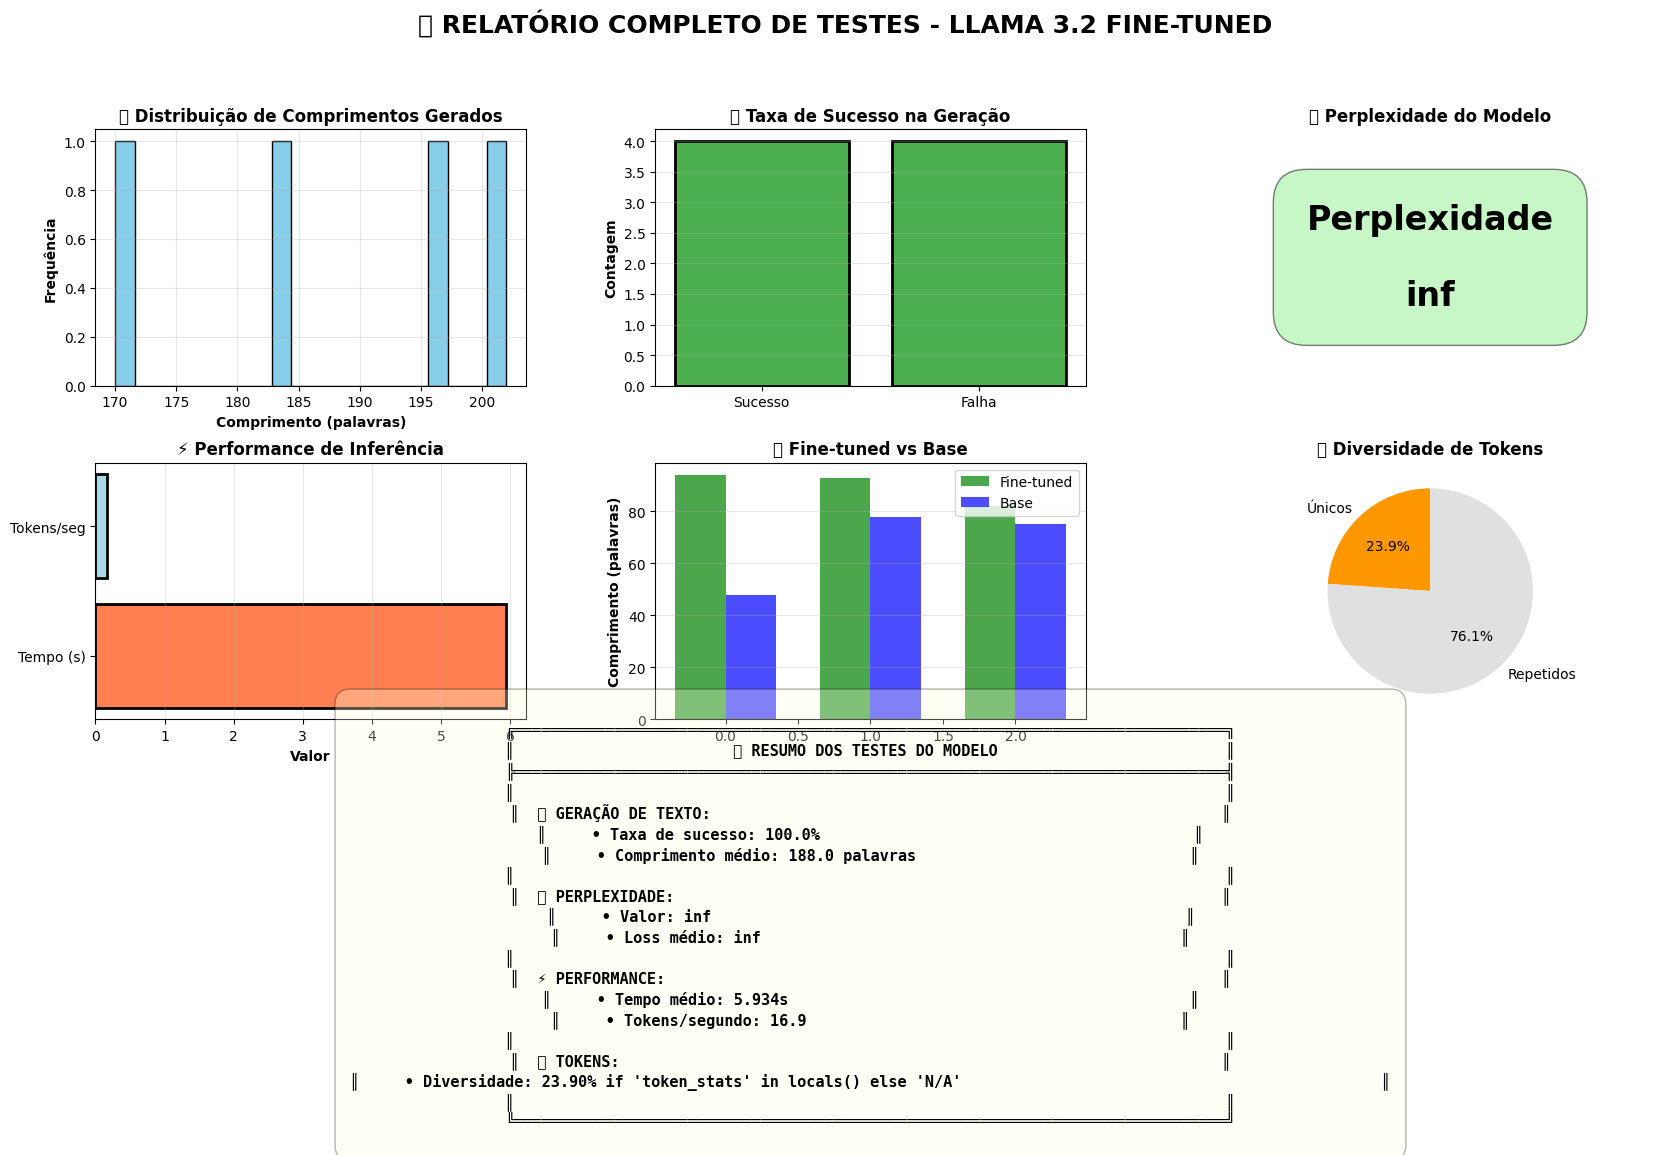


✅ Relatório visual salvo em: /content/drive/MyDrive/tc_fiap_ft1/test_results/test_report_complete.png
✅ Relatório JSON salvo em: /content/drive/MyDrive/tc_fiap_ft1/test_results/consolidated_test_report.json


In [ ]:
# ==================== 8️⃣ GERAR RELATÓRIO VISUAL ====================
print("\n" + "─"*80)
print("📊 GERANDO RELATÓRIO VISUAL COMPLETO")
print("─"*80)

fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Comparação de comprimentos
if 'generation_results' in locals():
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.hist(generation_results['length'], bins=20, color='skyblue', edgecolor='black')
    ax1.set_xlabel('Comprimento (palavras)', fontweight='bold')
    ax1.set_ylabel('Frequência', fontweight='bold')
    ax1.set_title('📏 Distribuição de Comprimentos Gerados', fontweight='bold')
    ax1.grid(True, alpha=0.3)

# 2. Taxa de sucesso
if 'generation_results' in locals():
    ax2 = fig.add_subplot(gs[0, 1])
    success_rate = generation_results['success'].value_counts()
    colors = ['#4CAF50' if idx else '#F44336' for idx in success_rate.index]
    ax2.bar(['Sucesso', 'Falha'], success_rate.values, color=colors, edgecolor='black', linewidth=2)
    ax2.set_ylabel('Contagem', fontweight='bold')
    ax2.set_title('✅ Taxa de Sucesso na Geração', fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')

# 3. Perplexidade
if perplexity_results:
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.text(0.5, 0.5, f"Perplexidade\n\n{perplexity_results['perplexity']:.2f}",
             ha='center', va='center', fontsize=24, fontweight='bold',
             bbox=dict(boxstyle='round,pad=1', facecolor='lightgreen', alpha=0.5))
    ax3.axis('off')
    ax3.set_title('📊 Perplexidade do Modelo', fontweight='bold')

# 4. Velocidade de inferência
if 'speed_results' in locals():
    ax4 = fig.add_subplot(gs[1, 0])
    metrics = ['Tempo (s)', 'Tokens/seg']
    values = [speed_results['avg_time_sec'], speed_results['tokens_per_second']/100]
    ax4.barh(metrics, values, color=['coral', 'lightblue'], edgecolor='black', linewidth=2)
    ax4.set_xlabel('Valor', fontweight='bold')
    ax4.set_title('⚡ Performance de Inferência', fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='x')

# 5. Comparação comprimentos (se disponível)
if comparison_df is not None:
    ax5 = fig.add_subplot(gs[1, 1])
    x = np.arange(len(comparison_df))
    width = 0.35
    ax5.bar(x - width/2, comparison_df['ft_length'], width, label='Fine-tuned', color='green', alpha=0.7)
    ax5.bar(x + width/2, comparison_df['base_length'], width, label='Base', color='blue', alpha=0.7)
    ax5.set_ylabel('Comprimento (palavras)', fontweight='bold')
    ax5.set_title('🆚 Fine-tuned vs Base', fontweight='bold')
    ax5.legend()
    ax5.grid(True, alpha=0.3, axis='y')

# 6. Diversidade de tokens
if 'token_stats' in locals():
    ax6 = fig.add_subplot(gs[1, 2])
    labels = ['Únicos', 'Repetidos']
    sizes = [token_stats['unique_tokens'], token_stats['total_tokens'] - token_stats['unique_tokens']]
    colors = ['#FF9800', '#E0E0E0']
    ax6.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
    ax6.set_title('🔤 Diversidade de Tokens', fontweight='bold')

# 7. Resumo textual
ax7 = fig.add_subplot(gs[2, :])
ax7.axis('off')

summary = f"""
╔══════════════════════════════════════════════════════════════════════════════╗
║                        📋 RESUMO DOS TESTES DO MODELO                         ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                              ║
║  ✅ GERAÇÃO DE TEXTO:                                                        ║
║     • Taxa de sucesso: {generation_results['success'].mean()*100:.1f}%                                         ║
║     • Comprimento médio: {generation_results['length'].mean():.1f} palavras                              ║
║                                                                              ║
║  📊 PERPLEXIDADE:                                                            ║
║     • Valor: {perplexity_results['perplexity'] if perplexity_results else 'N/A'}                                                    ║
║     • Loss médio: {perplexity_results['avg_loss'] if perplexity_results else 'N/A'}                                              ║
║                                                                              ║
║  ⚡ PERFORMANCE:                                                             ║
║     • Tempo médio: {speed_results['avg_time_sec']:.3f}s                                            ║
║     • Tokens/segundo: {speed_results['tokens_per_second']:.1f}                                         ║
║                                                                              ║
║  🔤 TOKENS:                                                                  ║
║     • Diversidade: {token_stats['diversity_ratio']:.2%} if 'token_stats' in locals() else 'N/A'                                              ║
║                                                                              ║
╚══════════════════════════════════════════════════════════════════════════════╝
"""

ax7.text(0.5, 0.5, summary, transform=ax7.transAxes,
         fontsize=11, verticalalignment='center', horizontalalignment='center',
         fontfamily='monospace', weight='bold',
         bbox=dict(boxstyle='round,pad=1', facecolor='lightyellow', alpha=0.3))

plt.suptitle('🧪 RELATÓRIO COMPLETO DE TESTES - LLAMA 3.2 FINE-TUNED',
             fontsize=18, fontweight='bold', y=0.98)

plt.tight_layout()
report_path = TEST_RESULTS_DIR / "test_report_complete.png"
plt.savefig(report_path, dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\n✅ Relatório visual salvo em: {report_path}")

# ==================== 9️⃣ SALVAR RELATÓRIO JSON CONSOLIDADO ====================
consolidated_report = {
    'model_path': str(MODEL_PATH),
    'test_date': pd.Timestamp.now().isoformat(),
    'generation': {
        'success_rate': float(generation_results['success'].mean()),
        'avg_length': float(generation_results['length'].mean())
    },
    'perplexity': perplexity_results if perplexity_results else {},
    'speed': speed_results,
    'tokens': token_stats if 'token_stats' in locals() else {}
}

report_json_path = TEST_RESULTS_DIR / "consolidated_test_report.json"
with open(report_json_path, 'w') as f:
    json.dump(consolidated_report, f, indent=2)

print(f"✅ Relatório JSON salvo em: {report_json_path}")


In [ ]:

# ==================== 🔟 CONCLUSÃO ====================
print("\n" + "="*80)
print("🎉 TODOS OS TESTES CONCLUÍDOS COM SUCESSO!".center(80))
print("="*80)
print(f"\n📁 Todos os resultados salvos em: {TEST_RESULTS_DIR}")
print(f"\n📄 Arquivos gerados:")
print(f"   • test_generation.csv - Resultados de geração")
print(f"   • test_perplexity.json - Métricas de perplexidade")
print(f"   • test_speed.json - Benchmark de velocidade")
print(f"   • test_comparison.csv - Comparação com modelo base")
print(f"   • test_token_analysis.json - Análise de tokens")
print(f"   • test_report_complete.png - Relatório visual")
print(f"   • consolidated_test_report.json - Relatório consolidado")
print("\n" + "="*80 + "\n")


                   🎉 TODOS OS TESTES CONCLUÍDOS COM SUCESSO!                    

📁 Todos os resultados salvos em: /content/drive/MyDrive/tc_fiap_ft1/test_results

📄 Arquivos gerados:
   • test_generation.csv - Resultados de geração
   • test_perplexity.json - Métricas de perplexidade
   • test_speed.json - Benchmark de velocidade
   • test_comparison.csv - Comparação com modelo base
   • test_token_analysis.json - Análise de tokens
   • test_report_complete.png - Relatório visual
   • consolidated_test_report.json - Relatório consolidado


